In [132]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
from torch import nn, tensor, optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torch.utils.data import default_collate
from operator import itemgetter
import fastcore.all as fc
import numpy as np
import math
from itertools import zip_longest

In [31]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(42)
mpl.rcParams['image.cmap'] = 'gray'

In [32]:
ds = load_dataset('fashion_mnist')
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [33]:
train = ds['train']
valid = ds['test']

train

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [34]:
x, y = train.features
x,y

('image', 'label')

In [35]:
ylbl = train.features[y]
ylbl

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [36]:
train[x][0], train[y][0]

(<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>, 9)

(<matplotlib.image.AxesImage at 0x7f7ac12f7be0>, 'Ankle boot')

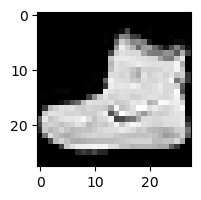

In [37]:
_, ax = plt.subplots(figsize=(2,2))
ax.imshow(train[x][0]), ylbl.int2str(train[y][0])

In [38]:
def collate_fn(b):
    return {
        x: torch.stack([TF.to_tensor(o[x]) for o in b]),
        y: tensor([o[y] for o in b])
    }

In [39]:
dl_train = DataLoader(train, batch_size=16, collate_fn=collate_fn)

b = next(iter(dl_train))
b[x].shape, b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [40]:
def transformi(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]
    return b

In [41]:
train_tr = train.with_transform(transformi)
train_tr

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [42]:
dl_train_2 = DataLoader(train_tr, batch_size=4)

b = next(iter(dl_train_2))
b[x].shape, b[y]

(torch.Size([4, 1, 28, 28]), tensor([9, 0, 0, 3]))

In [43]:
def tranformi_2(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]

In [44]:
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [45]:
tranformi_3 = inplace(tranformi_2)

In [46]:
train_tr_3 = train.with_transform(tranformi_3)
dl_train_3 = DataLoader(train_tr_3, batch_size=4)

b = next(iter(dl_train_3))
b[x].shape, b[y]

(torch.Size([4, 1, 28, 28]), tensor([9, 0, 0, 3]))

In [47]:
@inplace
def tranformi_4(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]

In [48]:
train_tr_4 = train.with_transform(tranformi_4)
dl_train_4 = DataLoader(train_tr_4, batch_size=4)

b = next(iter(dl_train_4))
b[x].shape, b[y]

(torch.Size([4, 1, 28, 28]), tensor([9, 0, 0, 3]))

In [49]:
def collate_fn_2(ds):
    ig = itemgetter(*ds.features)
    def _f(b):
        return ig(default_collate(b))
    return _f

In [50]:
train_tr_5 = train.with_transform(tranformi_4)
dl_train_5 = DataLoader(train_tr_5, batch_size=4, collate_fn=collate_fn_2(train_tr_5))

xb,yb = next(iter(dl_train_5))
xb.shape, yb

(torch.Size([4, 1, 28, 28]), tensor([9, 0, 0, 3]))

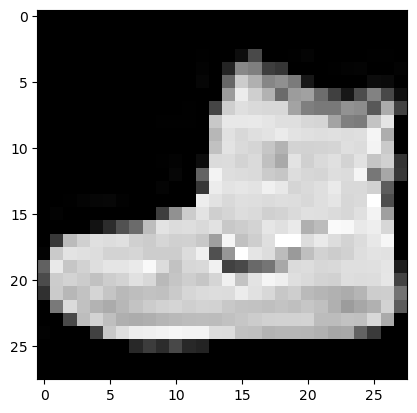

In [51]:
b = next(iter(dl_train))
xb = b['image']
img = xb[0]
plt.imshow(img[0])

In [162]:
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

<Axes: >

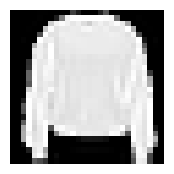

In [163]:
show_image(img, figsize=(2,2))

<Axes: >

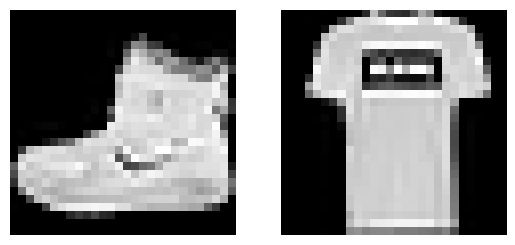

In [164]:
fig,axs = plt.subplots(1,2)
show_image(xb[0], axs[0])
show_image(xb[1],axs[1] )

In [165]:
@fc.delegates(plt.subplot)
def subplots(nrows=1, ncols=1, figsize=None, imsize=3,suptitle=None, **kwargs):
    if figsize is None: figsize = (ncols*imsize,nrows*imsize)
    fig,axs = plt.subplots(nrows,ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols == 1: axs = np.array([axs])
    return fig, axs

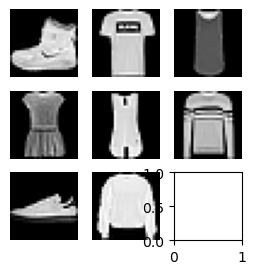

In [166]:
fig,axs = subplots(3,3, imsize=1)
imgs = xb[:8]
for ax,img in zip(axs.flat,imgs): show_image(img, ax)


In [167]:
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

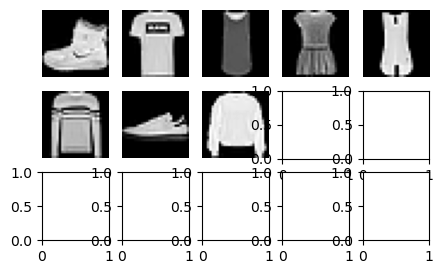

In [168]:
fig,axs = get_grid(15, imsize=1)
for im,ax in zip(imgs, axs.flat): show_image(im,ax)

In [169]:
@fc.delegates(subplots)
def show_images(ims,nrows=None,ncols=None,titles=None,**kwargs):
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,ax,title in zip_longest(ims, axs, titles or []):show_image(im,ax=ax,title=title)

In [170]:
yb = b['label']
lbls = yb[:8]
     

names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
titles = itemgetter(*lbls)(names)
' '.join(titles)

'Boot Top Top Dress Top Pullover Sneaker Pullover'

In [175]:
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
names

['Top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Boot']

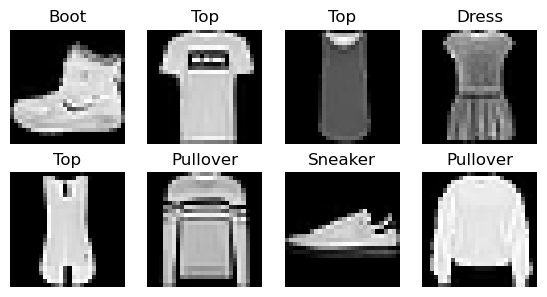

In [173]:
show_images(imgs, imsize=1.7, titles=titles)